# Fertilizer Recommendation EDA and Training Helper

This notebook explores the fertilizer dataset and scaffolds a training + inference pipeline for AgroAssist-ML (Fertilizer Recommendation System).

What you'll do:
- Inspect data structure, missing values, and distributions
- Identify target column and feature types
- Visualize distributions, correlations, and class balance
- Generate the training script (`src/train_fertilizer.py`)
- Generate a tiny inference tester (`src/test_fertilizer_inference.py`)

Run cells top-to-bottom. If any import error occurs, ensure your venv is selected in VS Code.

In [34]:
# 1) Set Up Environment and Paths
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import display
plt.style.use('seaborn-v0_8')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Resolve fertilizer dataset path flexibly (supports data/ and data/raw/ and common names),
# and also works when running from the notebooks/ folder.
def find_data_file():
    here = Path.cwd()
    candidate_roots = [here / 'data', here.parent / 'data', here.parent.parent / 'data']
    names = ['fertilizer.csv', 'Fertilizer Prediction.csv']
    # Direct candidates
    for root in candidate_roots:
        for name in names:
            for sub in [Path('.'), Path('raw')]:
                p = root / sub / name
                if p.exists():
                    return p
    # Fallback: search for any CSV in data trees containing 'fert'
    for root in candidate_roots:
        if root.exists():
            for p in root.rglob('*.csv'):
                if 'fert' in p.name.lower():
                    return p
    raise FileNotFoundError(
        'Could not find fertilizer CSV under data/ or data/raw/ (e.g., data/fertilizer.csv).'
    )

DATA_PATH = find_data_file()
MODELS_DIR = (Path.cwd() if (Path.cwd() / 'models').exists() else Path.cwd().parent) / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
pd.set_option('display.max_columns', None)

print('Notebook ready. DATA_PATH =', DATA_PATH.resolve())
print('MODELS_DIR =', MODELS_DIR.resolve())

Notebook ready. DATA_PATH = C:\Users\Snehal\Agroassist-ML\data\Fertilizer Prediction.csv
MODELS_DIR = C:\Users\Snehal\Agroassist-ML\notebooks\models


In [35]:
# 2) Load Dataset
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. Ensure the fertilizer CSV is under data/ or data/raw/. Current search resolved to: {DATA_PATH}"
    )

print('Shape:', df.shape)
display(df.head(3))
display(df.tail(3))
display(df.dtypes)

Shape: (99, 9)


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
96,38,72,51,Loamy,Wheat,39,0,0,Urea
97,36,60,43,Sandy,Millets,15,0,41,DAP
98,29,58,57,Black,Sugarcane,12,0,10,20-20


Temparature         int64
Humidity            int64
Moisture            int64
Soil Type          object
Crop Type          object
Nitrogen            int64
Potassium           int64
Phosphorous         int64
Fertilizer Name    object
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
count,99.000000,99.000000,99.000000,99,99,99.000000,99.000000,99.000000,99
unique,NaN,NaN,NaN,5,11,NaN,NaN,NaN,7
top,NaN,NaN,NaN,Loamy,Sugarcane,NaN,NaN,NaN,Urea
freq,NaN,NaN,NaN,21,13,NaN,NaN,NaN,22
mean,30.282828,59.151515,43.181818,NaN,NaN,18.909091,3.383838,18.606061,NaN
std,3.502304,5.840331,11.271568,NaN,NaN,11.599693,5.814667,13.476978,NaN
min,25.000000,50.000000,25.000000,NaN,NaN,4.000000,0.000000,0.000000,NaN
25%,28.000000,54.000000,34.000000,NaN,NaN,10.000000,0.000000,9.000000,NaN
50%,30.000000,60.000000,41.000000,NaN,NaN,13.000000,0.000000,19.000000,NaN
75%,33.000000,64.000000,50.500000,NaN,NaN,24.000000,7.500000,30.000000,NaN


No missing values found.


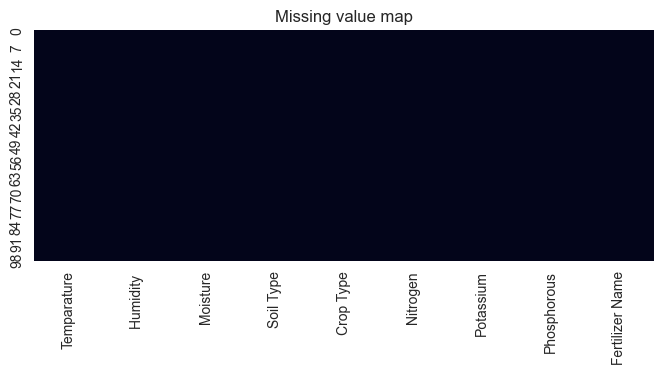

Duplicates: 0


In [36]:
# 3) Inspect Structure and Missing Values
print('Info:')
df.info()

try:
    display(df.describe(include='all'))
except Exception as e:
    print('describe(include="all") failed:', e)

miss = df.isna().sum().sort_values(ascending=False)
missing_df = miss[miss > 0]
if not missing_df.empty:
    display(missing_df)
else:
    print('No missing values found.')

plt.figure(figsize=(8, 3))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing value map')
plt.show()

dups = df.duplicated().sum()
print(f'Duplicates: {dups}')

In [37]:
# 4) Identify Feature Types and Target Column
# Robust target detection: handle case/space/underscore differences

def _norm(s):
    return str(s).strip().lower().replace('_', '').replace(' ', '')

# Known variants seen in common datasets
_target_aliases = [
    'fertilizer_name', 'fertilizername', 'fertilizer',
    'fertilizerlabel', 'label', 'target'
]

normalized_cols = { _norm(c): c for c in df.columns }

y_col = None
for alias in _target_aliases:
    if alias in normalized_cols:
        y_col = normalized_cols[alias]
        break

# Fallback: try to guess from columns that contain the word 'fertilizer'
if y_col is None:
    fert_like = [c for c in df.columns if 'fertilizer' in c.lower()]
    if len(fert_like) == 1:
        y_col = fert_like[0]

assert y_col is not None, 'Target column not found'

X = df.drop(columns=[y_col])
y = df[y_col].astype(str)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print('Target:', y_col)
print('Numeric:', num_cols)
print('Categorical:', cat_cols)

Target: Fertilizer Name
Numeric: ['Temparature', 'Humidity ', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical: ['Soil Type', 'Crop Type']


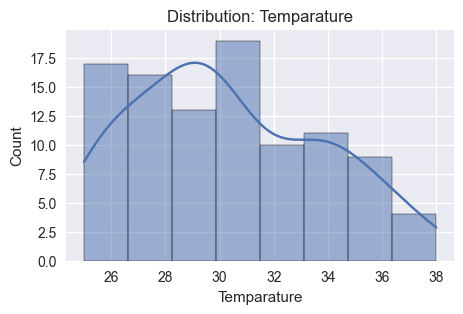

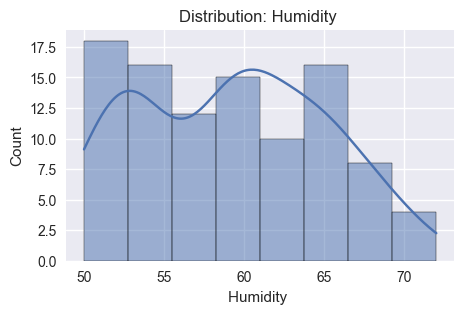

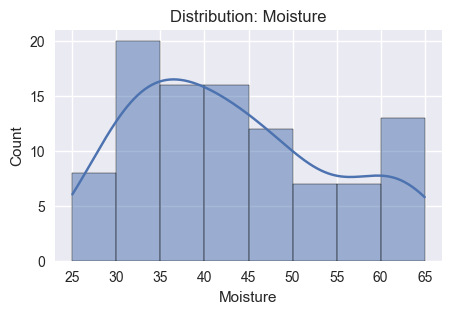

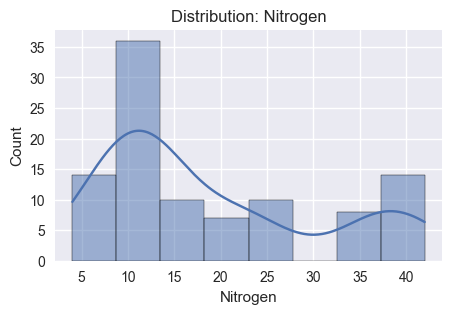

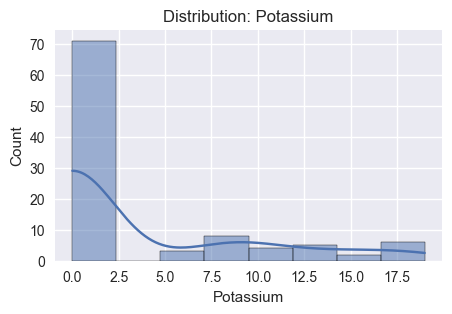

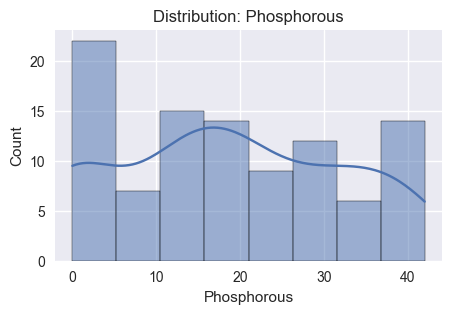

In [38]:
# 5) Numeric Feature Distributions
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
    plt.show()

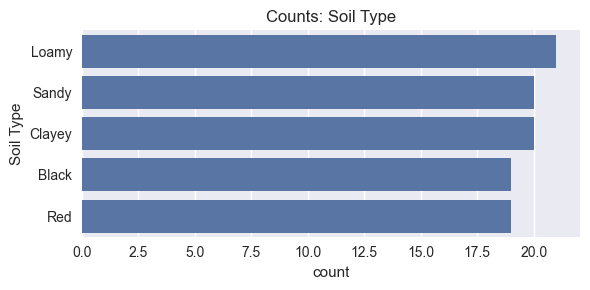

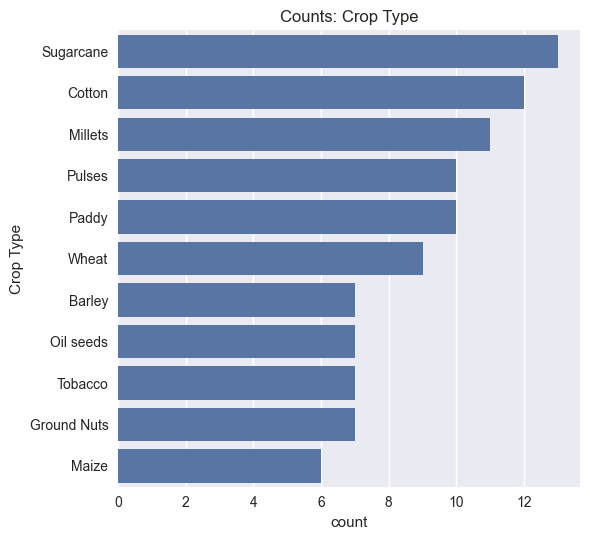

In [39]:
# 6) Categorical Feature Distributions
for col in cat_cols:
    if df[col].isna().all():
        continue
    plt.figure(figsize=(6, max(3, min(8, df[col].nunique()/2))))
    order = df[col].value_counts().index
    sns.countplot(y=df[col], order=order)
    plt.title(f'Counts: {col}')
    plt.tight_layout()
    plt.show()

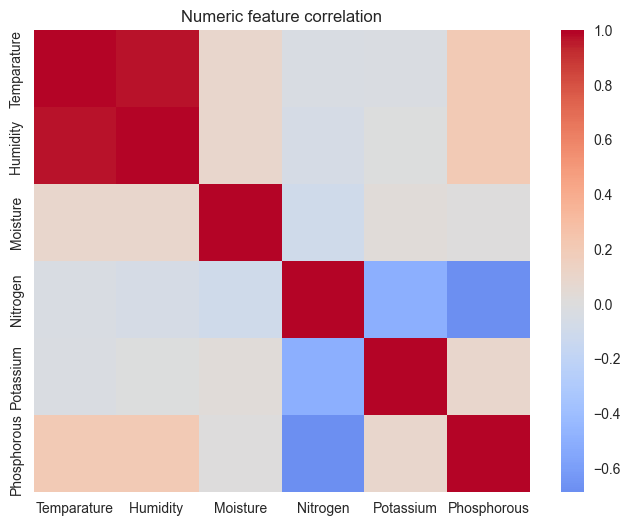

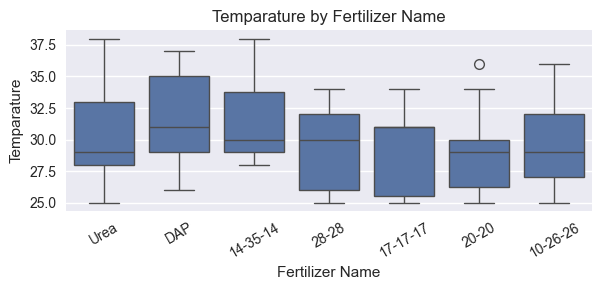

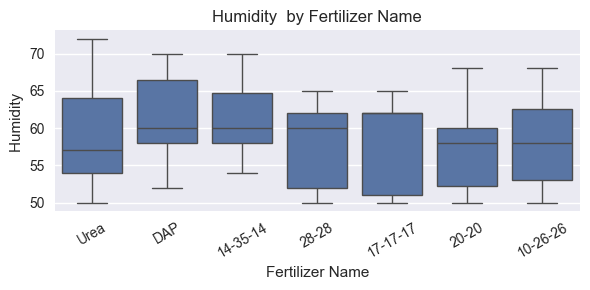

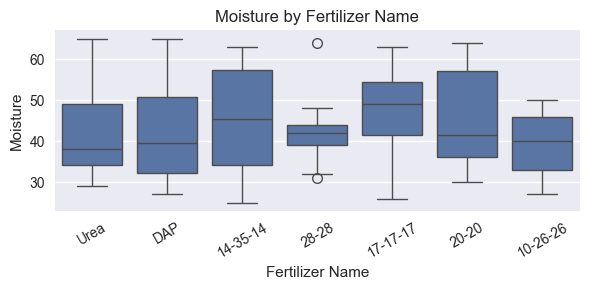

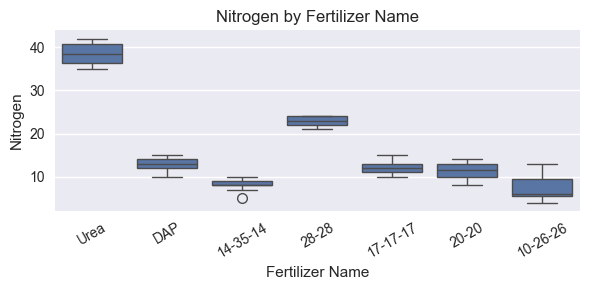

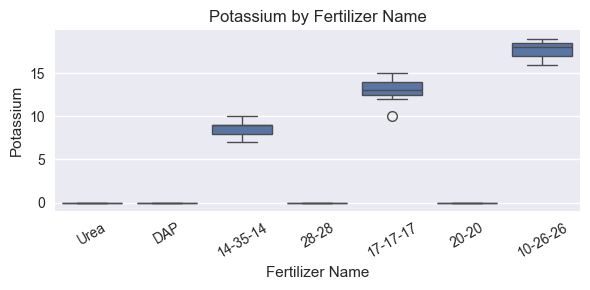

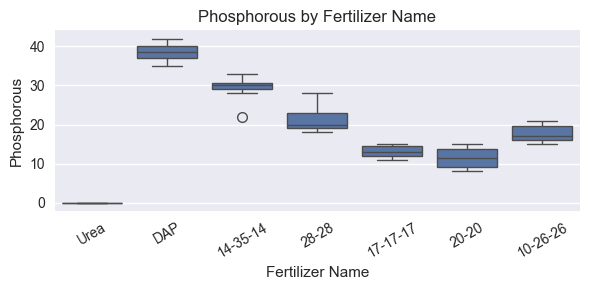

In [40]:
# 7) Correlations (Numeric) and Feature-Target Insight
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Numeric feature correlation')
    plt.show()

if y.nunique() <= 10 and len(num_cols) > 0:
    for col in num_cols[:6]:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=y, y=df[col])
        plt.title(f'{col} by {y_col}')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

,count,ratio
Fertilizer Name,,
Urea,22,0.222
DAP,18,0.182
28-28,17,0.172
14-35-14,14,0.141
20-20,14,0.141
17-17-17,7,0.071
10-26-26,7,0.071


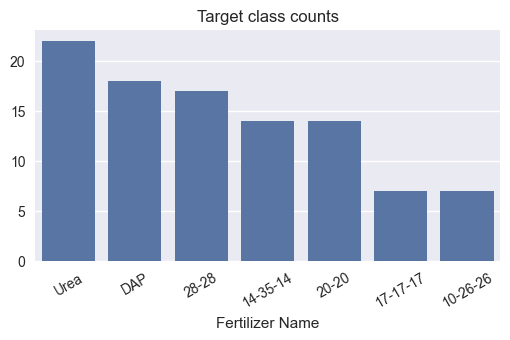

Imbalance ratio (max/min): 3.14
Notice: dataset appears imbalanced. Consider class_weight or oversampling (see later sections).


In [41]:
# 8) Target Balance and Imbalance Check
vc = y.value_counts()
vcn = y.value_counts(normalize=True)
display(pd.DataFrame({'count':vc, 'ratio':vcn.round(3)}))

plt.figure(figsize=(6,3))
sns.barplot(x=vc.index, y=vc.values)
plt.title('Target class counts')
plt.xticks(rotation=30)
plt.show()

imb_ratio = vc.max() / max(1, vc.min())
print(f'Imbalance ratio (max/min): {imb_ratio:.2f}')
if imb_ratio > 1.5:
    print('Notice: dataset appears imbalanced. Consider class_weight or oversampling (see later sections).')

In [42]:
# 9) Create Training Script src/train_fertilizer.py (robust write)
from pathlib import Path as _P

_script_root = _P.cwd() if (_P.cwd() / 'src').exists() else _P.cwd().parent
_outfile = _script_root / 'src' / 'train_fertilizer.py'
_outfile.parent.mkdir(parents=True, exist_ok=True)

_train_script = r'''#!/usr/bin/env python3
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Flexible dataset resolution supporting execution from repo root or notebooks/
def find_data_file():
    cwd = Path.cwd()
    candidate_roots = [cwd / 'data', cwd.parent / 'data', cwd.parent.parent / 'data']
    candidate_names = [
        'fertilizer.csv',
        'Fertilizer Prediction.csv',
        # tolerate common misspellings
        'fertlizer_perdiction.csv',
        'fertilizer_prediction.csv',
    ]
    # Direct candidates in data/ and data/raw/
    for root in candidate_roots:
        for name in candidate_names:
            for sub in [Path('.'), Path('raw')]:
                p = root / sub / name
                if p.exists():
                    return p
    # Fallback: search any CSV with 'fert' in name under data trees
    for root in candidate_roots:
        if root.exists():
            for p in root.rglob('*.csv'):
                n = p.name.lower()
                if 'fert' in n:
                    return p
    raise FileNotFoundError('Could not find fertilizer CSV under data/ or data/raw/.')

DATA_PATH = find_data_file()
# Ensure models/ resolves correctly when run from repo root or notebooks/
MODELS_DIR = (Path.cwd() if (Path.cwd() / 'models').exists() else Path.cwd().parent) / 'models'

# Robust target detection that tolerates spaces/underscores/case
_DEF_TARGET_ALIASES = [
    'fertilizer_name', 'fertilizername', 'fertilizer',
    'fertilizerlabel', 'label', 'target'
]

def _norm(s):
    return str(s).strip().lower().replace('_', '').replace(' ', '')

def find_target(df):
    normalized_cols = { _norm(c): c for c in df.columns }
    for alias in _DEF_TARGET_ALIASES:
        if alias in normalized_cols:
            return normalized_cols[alias]
    fert_like = [c for c in df.columns if 'fertilizer' in c.lower()]
    if len(fert_like) == 1:
        return fert_like[0]
    raise ValueError('Target column not found in dataset')

def main():
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    df = pd.read_csv(DATA_PATH)
    y_col = find_target(df)
    X = df.drop(columns=[y_col])
    y = df[y_col].astype(str)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    print(f'Using DATA_PATH: {DATA_PATH.resolve()}')
    print(f'Using target: {y_col}')
    print(f'Numeric: {num_cols}')
    print(f'Categorical: {cat_cols}')
    # Label encode target and save
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    joblib.dump(le, MODELS_DIR / 'fert_labelencoder.joblib')
    # Preprocess features (guard empty column lists)
    transformers = []
    if len(num_cols) > 0:
        transformers.append(('num', StandardScaler(), num_cols))
    if len(cat_cols) > 0:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols))
    if not transformers:
        raise ValueError('No features found to train on (no numeric or categorical columns).')
    preprocessor = ColumnTransformer(transformers)
    # Model (class_weight helps imbalance)
    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced')
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('clf', clf)])
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
    # Train
    pipe.fit(X_train, y_train)
    # Evaluate
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc:.4f}')
    print('Classification report:')
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))
    # Save model pipeline and scaler artifact
    joblib.dump(pipe, MODELS_DIR / 'fert_model.joblib')
    # Save scaler if numeric branch exists
    try:
        scaler = pipe.named_steps['preprocess'].named_transformers_.get('num')
    except Exception:
        scaler = None
    if scaler is not None:
        joblib.dump(scaler, MODELS_DIR / 'fert_scaler.joblib')
    print('Saved models/fert_model.joblib, models/fert_scaler.joblib (if any), models/fert_labelencoder.joblib')

if __name__ == '__main__':
    sys.exit(main())
'''

_outfile.write_text(_train_script, encoding='utf-8')
print('Wrote training script to', _outfile)

Wrote training script to c:\Users\Snehal\Agroassist-ML\src\train_fertilizer.py


### 10) Run Training Script and View Metrics
- In notebook: run the next cell to train.
- In terminal (PowerShell):

```
C:/Users/Snehal/Agroassist-ML/venv/Scripts/python.exe src/train_fertilizer.py
```

This prints accuracy and a classification report, and saves artifacts to `models/`:
- models/fert_model.joblib
- models/fert_scaler.joblib
- models/fert_labelencoder.joblib

In [43]:
# Train now (robust execution from notebook)
import runpy
import sys
from pathlib import Path as _P
_script_root = _P.cwd() if (_P.cwd() / 'src').exists() else _P.cwd().parent
sys.path.insert(0, str(_script_root))
print('Executing:', _script_root / 'src' / 'train_fertilizer.py')
try:
    runpy.run_path(str(_script_root / 'src' / 'train_fertilizer.py'), run_name='__main__')
except SystemExit:
    # The script calls sys.exit(...); swallow it so the notebook doesn't show an error
    pass
print('Training script finished.')

Executing: c:\Users\Snehal\Agroassist-ML\src\train_fertilizer.py
Using DATA_PATH: C:\Users\Snehal\Agroassist-ML\data\Fertilizer Prediction.csv
Using target: Fertilizer Name
Numeric: ['Temparature', 'Humidity ', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical: ['Soil Type', 'Crop Type']
Accuracy: 1.0000
Classification report:
              precision    recall  f1-score   support

    10-26-26       1.00      1.00      1.00         1
    14-35-14       1.00      1.00      1.00         3
    17-17-17       1.00      1.00      1.00         1
       20-20       1.00      1.00      1.00         3
       28-28       1.00      1.00      1.00         3
         DAP       1.00      1.00      1.00         4
        Urea       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy: 1.0000
Classification report:
              precis

In [44]:
# 11) Create Inference Test Script src/test_fertilizer_inference.py (robust write)
from pathlib import Path as _P

_script_root = _P.cwd() if (_P.cwd() / 'src').exists() else _P.cwd().parent
_outfile = _script_root / 'src' / 'test_fertilizer_inference.py'
_outfile.parent.mkdir(parents=True, exist_ok=True)

_test_script = r'''#!/usr/bin/env python3
from pathlib import Path
import pandas as pd
import joblib

# Robust target detection
_DEF_TARGET_ALIASES = [
    'fertilizer_name', 'fertilizername', 'fertilizer',
    'fertilizerlabel', 'label', 'target'
]

def _norm(s):
    return str(s).strip().lower().replace('_', '').replace(' ', '')

def find_target(df):
    normalized_cols = { _norm(c): c for c in df.columns }
    for alias in _DEF_TARGET_ALIASES:
        if alias in normalized_cols:
            return normalized_cols[alias]
    fert_like = [c for c in df.columns if 'fertilizer' in c.lower()]
    if len(fert_like) == 1:
        return fert_like[0]
    raise ValueError('Target column not found')

# Flexible dataset resolution supporting execution from repo root or notebooks/
def find_data_file():
    cwd = Path.cwd()
    candidate_roots = [cwd / 'data', cwd.parent / 'data', cwd.parent.parent / 'data']
    candidate_names = [
        'fertilizer.csv',
        'Fertilizer Prediction.csv',
        'fertlizer_perdiction.csv',
        'fertilizer_prediction.csv',
    ]
    for root in candidate_roots:
        for name in candidate_names:
            for sub in [Path('.'), Path('raw')]:
                p = root / sub / name
                if p.exists():
                    return p
    for root in candidate_roots:
        if root.exists():
            for p in root.rglob('*.csv'):
                n = p.name.lower()
                if 'fert' in n:
                    return p
    raise FileNotFoundError('Could not find fertilizer CSV under data/ or data/raw/.')

DATA_PATH = find_data_file()
# Resolve models when run from repo root or notebooks/
MODELS_DIR = (Path.cwd() if (Path.cwd() / 'models').exists() else Path.cwd().parent) / 'models'

def main():
    model = joblib.load(MODELS_DIR / 'fert_model.joblib')
    le = joblib.load(MODELS_DIR / 'fert_labelencoder.joblib')
    df = pd.read_csv(DATA_PATH)
    y_col = find_target(df)
    X = df.drop(columns=[y_col])
    sample = X.iloc[[0]].copy()
    pred_enc = model.predict(sample)
    pred = le.inverse_transform(pred_enc)
    print('Using DATA_PATH:', DATA_PATH.resolve())
    print('Using MODELS_DIR:', MODELS_DIR.resolve())
    print('Sample input:')
    print(sample.to_dict(orient='records')[0])
    print(f'Predicted fertilizer: {pred[0]}')

if __name__ == '__main__':
    main()
'''

_outfile.write_text(_test_script, encoding='utf-8')
print('Wrote inference test script to', _outfile)

Wrote inference test script to c:\Users\Snehal\Agroassist-ML\src\test_fertilizer_inference.py


### 12) Run Inference Test Script
- In notebook: run the next cell to test.
- In terminal:

```
C:/Users/Snehal/Agroassist-ML/venv/Scripts/python.exe src/test_fertilizer_inference.py
```

You should see a sample input and the predicted fertilizer printed.

In [45]:
# Run inference test now (robust execution)
import runpy
import sys
from pathlib import Path as _P
_script_root = _P.cwd() if (_P.cwd() / 'src').exists() else _P.cwd().parent
sys.path.insert(0, str(_script_root))
print('Executing:', _script_root / 'src' / 'test_fertilizer_inference.py')
runpy.run_path(str(_script_root / 'src' / 'test_fertilizer_inference.py'), run_name='__main__')

Executing: c:\Users\Snehal\Agroassist-ML\src\test_fertilizer_inference.py
Using DATA_PATH: C:\Users\Snehal\Agroassist-ML\data\Fertilizer Prediction.csv
Using MODELS_DIR: C:\Users\Snehal\Agroassist-ML\notebooks\models
Sample input:
{'Temparature': 26, 'Humidity ': 52, 'Moisture': 38, 'Soil Type': 'Sandy', 'Crop Type': 'Maize', 'Nitrogen': 37, 'Potassium': 0, 'Phosphorous': 0}
Predicted fertilizer: Urea
Using DATA_PATH: C:\Users\Snehal\Agroassist-ML\data\Fertilizer Prediction.csv
Using MODELS_DIR: C:\Users\Snehal\Agroassist-ML\notebooks\models
Sample input:
{'Temparature': 26, 'Humidity ': 52, 'Moisture': 38, 'Soil Type': 'Sandy', 'Crop Type': 'Maize', 'Nitrogen': 37, 'Potassium': 0, 'Phosphorous': 0}
Predicted fertilizer: Urea


{'__name__': '__main__',
 '__doc__': None,
 '__package__': '',
 '__loader__': None,
 '__spec__': None,
 '__file__': 'c:\\Users\\Snehal\\Agroassist-ML\\src\\test_fertilizer_inference.py',
 '__cached__': None,
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__(name, globals=None, locals

### 13) Optional: Handle Imbalance with Class Weights
`RandomForestClassifier(..., class_weight='balanced')` is already used. To compare, edit the training script to `class_weight=None` and re-run training to see how metrics change (especially per-class F1).

### 14) Optional: Handle Imbalance with SMOTE Oversampling
Install once if needed: `pip install imbalanced-learn`

In `src/train_fertilizer.py`, you can replace the pipeline with imbalanced-learn:

```python
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
pipe = ImbPipeline(steps=[('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', clf)])
```

Re-train and compare metrics. Note: SMOTE on high-cardinality one-hot features may be slow.

In [ ]:
# 15) Optional: Save and Load Artifacts Validation
from pathlib import Path as _Path
import joblib as _joblib
m = _joblib.load(_Path('models/fert_model.joblib'))
le = _joblib.load(_Path('models/fert_labelencoder.joblib'))
sc = _joblib.load(_Path('models/fert_scaler.joblib'))
print(type(m), type(le), type(sc))

<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.preprocessing._label.LabelEncoder'> <class 'sklearn.preprocessing._data.StandardScaler'>


: 